In [14]:
import numpy as np
# for vectorized math,arrays ftns etc
import copy

import matplotlib.pyplot as plt
# for displaying graphs/plots

from PIL import Image
# to load and resize .jpg images

import os
# for handling file paths

from planar_utils import plot_decision_boundary, sigmoid

%matplotlib inline
# Ensures that plots (from plt) show inside Jupyter Notebook cells


In [3]:
import os
import numpy as np
from PIL import Image

def load_images_from_folder(folder_path, label, image_size):
    X = []
    Y = []

    if not os.path.exists(folder_path):
        print(f"❌ Folder does not exist: {folder_path}")
        return [], []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                X.append(np.array(img))
                Y.append(label)
            except Exception as e:
                print(f"❌ Error loading {img_path}: {e}")
    
    return X, Y

def load_dataset_seatbelt(base_dir="seatbelt_classification", image_size=(64, 64)):
    label_names = ["with_seatbelt", "without_seatbelt"]
    label_map = {name: i for i, name in enumerate(label_names)}

    X_train, Y_train = [], []
    X_test, Y_test = [], []

    for label_name in label_names:
        label = label_map[label_name]
        train_folder = os.path.join(base_dir, "train", label_name)
        test_folder = os.path.join(base_dir, "test", label_name)

        X_tr, Y_tr = load_images_from_folder(train_folder, label, image_size)
        X_te, Y_te = load_images_from_folder(test_folder, label, image_size)

        X_train.extend(X_tr)
        Y_train.extend(Y_tr)
        X_test.extend(X_te)
        Y_test.extend(Y_te)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    Y_train = np.array(Y_train).reshape(1, -1)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test).reshape(1, -1)

    classes = np.array(label_names)

    return X_train, Y_train, X_test, Y_test, classes


In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset_seatbelt()

In [5]:
print("Training set shape:", train_set_x_orig.shape, train_set_y.shape)
print("Test set shape:", test_set_x_orig.shape, test_set_y.shape)
print("Classes:", classes)

Training set shape: (1878, 64, 64, 3) (1, 1878)
Test set shape: (602, 64, 64, 3) (1, 602)
Classes: ['with_seatbelt' 'without_seatbelt']


In [6]:
# Flatten
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize (scale pixel values between 0 and 1)
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

print("train_set_x shape:", train_set_x.shape)
print("test_set_x shape:", test_set_x.shape)


train_set_x shape: (12288, 1878)
test_set_x shape: (12288, 602)


In [7]:

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer (i have fixed it to 4 currently)
    n_y -- the size of the output layer
    """
 
    n_x = X.shape[0]   # number of input features
    n_h = 4            # hidden layer size (4 neurons)
    n_y = Y.shape[0]   # number of output units (1 for binary classification)

    return (n_x, n_h, n_y)


In [8]:
n_x, n_h, n_y = layer_sizes(train_set_x, train_set_y)
print("Input layer size:", n_x)
print("Hidden layer size:", n_h)
print("Output layer size:", n_y)


Input layer size: 12288
Hidden layer size: 4
Output layer size: 1


In [9]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Initialize parameters for a 2-layer neural network

    Arguments:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- python dictionary containing:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    # small random values for weights, zeros for biases
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters


In [10]:
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


W1 = [[ 0.00143591 -0.00557524 -0.01590544 ... -0.00626677 -0.01086709
   0.0057898 ]
 [ 0.00737155  0.00685932  0.00618071 ... -0.00549376 -0.00943378
  -0.00798482]
 [-0.01753934 -0.01015909 -0.00144452 ...  0.00048303 -0.01026746
  -0.00217379]
 [ 0.00447677 -0.00368786 -0.00588464 ...  0.01755074 -0.00593458
   0.00342236]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.00619625  0.01174559 -0.00941538 -0.01453826]]
b2 = [[0.]]


In [11]:


def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    


    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    

    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [15]:
# Trying forward pass to check if it works correctly and produces the right shapes/initial values
A2, cache = forward_propagation(train_set_x, parameters)

print("A2 shape:", A2.shape)
print("A2 first few values:", A2[:, :5])  # show first 5 predictions


A2 shape: (1, 1878)
A2 first few values: [[0.50695947 0.5035201  0.50511946 0.50151725 0.50154694]]


In [16]:


def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1-A2))
    cost = -(1/m) * np.sum(logprobs)
    
    
   
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

In [20]:
# ===== Test the forward propagation and cost =====

# Get layer sizes from dataset
n_x, n_h, n_y = layer_sizes(train_set_x, train_set_y)

# Initialize parameters
parameters = initialize_parameters(n_x, n_h, n_y)

# Forward propagation on training set
A2, cache = forward_propagation(train_set_x, parameters)

# Compute cost with actual labels
cost = compute_cost(A2, train_set_y)

print("Initial A2 shape:", A2.shape)
print("First few A2 values:", A2[0, :5])
print("Initial cost:", cost)


Initial A2 shape: (1, 1878)
First few A2 values: [0.49768713 0.49892239 0.49822769 0.4960375  0.50174487]
Initial cost: 0.6935914342779417


In [21]:


def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".

    W1 = parameters["W1"]
    W2 = parameters["W2"]

        
    # Retrieve also A1 and A2 from dictionary "cache".

    A1 = cache["A1"]
    A2 = cache["A2"]
    

    # Backward propagation: calculate dW1, db1, dW2, db2. 

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot((W2.T),dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [24]:
grads = backward_propagation(parameters, cache, train_set_x, train_set_y)
print("dW1 = " + str(grads["dW1"]))
print("db1 = " + str(grads["db1"]))
print("dW2 = " + str(grads["dW2"]))
print("db2 = " + str(grads["db2"]))


dW1 = [[-1.00685696e-05 -1.08322788e-05 -9.71533315e-06 ...  9.87825561e-05
   1.04102616e-04  1.38826637e-04]
 [-8.64141349e-05 -8.84864352e-05 -8.45166704e-05 ...  1.10007301e-04
   1.15289785e-04  1.63695007e-04]
 [-1.09019553e-05 -1.00035476e-05 -1.64023372e-05 ... -4.62692274e-04
  -4.86330896e-04 -6.34351062e-04]
 [-2.50522448e-06 -3.12146103e-06 -2.28488126e-06 ...  5.65173875e-05
   5.99714921e-05  8.03544523e-05]]
db1 = [[ 8.81624355e-05]
 [-1.22173713e-05]
 [-5.00329948e-04]
 [ 5.17821218e-05]]
dW2 = [[0.01770369 0.0364876  0.00203446 0.0290796 ]]
db2 = [[0.02396596]]


In [25]:

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve a copy of each parameter from the dictionary "parameters".


    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]
    

    
    # Retrieve each gradient from the dictionary "grads"

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    

    
    # Update rule for each parameter

    W1 = W1 - np.multiply(learning_rate, dW1)
    b1 = b1 - np.multiply(learning_rate, db1)
    W2 = W2 - np.multiply(learning_rate, dW2)
    b2 = b2 - np.multiply(learning_rate, db2)
    

    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [26]:
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.23534279e-03  1.03030850e-03 -3.17408936e-03 ...  5.40704474e-03
  -4.39645419e-03 -6.16391209e-04]
 [ 2.33173283e-03 -7.34996080e-03 -9.43948134e-03 ... -1.16726591e-02
  -6.03098774e-03  4.19498774e-03]
 [-7.21822274e-04 -1.40128473e-05 -2.37942162e-03 ...  3.00605278e-03
   4.52246686e-03  1.55744183e-02]
 [ 4.03645747e-03  3.75609050e-03  2.70115651e-03 ...  1.42628296e-02
  -2.39676823e-04 -1.13356004e-02]]
b1 = [[-1.05794923e-04]
 [ 1.46608455e-05]
 [ 6.00395937e-04]
 [-6.21385462e-05]]
W2 = [[-0.01549968 -0.03547877 -0.02831066 -0.03153318]]
b2 = [[-0.02875915]]


In [27]:

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters

    parameters = initialize_parameters(n_x, n_h, n_y)

    # Loop (gradient descent)

    for i in range(0, num_iterations):
         

        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".

        
        # Cost function. Inputs: "A2, Y". Outputs: "cost".

 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".

 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".

        

        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        
        

        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [30]:
# Train the model
parameters = nn_model(train_set_x, train_set_y, n_h=4, num_iterations=10000, print_cost=True)


Cost after iteration 0: 0.692750
Cost after iteration 1000: 0.412312
Cost after iteration 2000: 0.383813
Cost after iteration 3000: 0.367983
Cost after iteration 4000: 0.384264
Cost after iteration 5000: 0.384694
Cost after iteration 6000: 0.276411
Cost after iteration 7000: 0.384910
Cost after iteration 8000: 0.384605
Cost after iteration 9000: 0.383858


In [28]:

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.

    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)


    
    return predictions

In [31]:
# Predict on training set
predictions_train = predict(parameters, train_set_x)
print("Train predictions: " + str(predictions_train))
print("Train accuracy: {} %".format(100 - np.mean(np.abs(predictions_train - train_set_y)) * 100))

# Predict on test set
predictions_test = predict(parameters, test_set_x)
print("Test predictions: " + str(predictions_test))
print("Test accuracy: {} %".format(100 - np.mean(np.abs(predictions_test - test_set_y)) * 100))


Train predictions: [[0 0 0 ... 1 1 1]]
Train accuracy: 83.65282215122471 %
Test predictions: [[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1
  1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
  0 0 0 0 0 0 0 0 1

In [34]:
parameters = nn_model(train_set_x, train_set_y, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.692750
Cost after iteration 1000: 0.412312
Cost after iteration 2000: 0.383813
Cost after iteration 3000: 0.367983
Cost after iteration 4000: 0.384264
Cost after iteration 5000: 0.384694
Cost after iteration 6000: 0.276411
Cost after iteration 7000: 0.384910
Cost after iteration 8000: 0.384605
Cost after iteration 9000: 0.383858


In [35]:
predictions = predict(parameters, train_set_x)

accuracy = ((np.dot(train_set_y, predictions.T) + np.dot(1 - train_set_y, 1 - predictions.T)) / train_set_y.size * 100).item()

print("Train Accuracy: %d%%" % accuracy)


Train Accuracy: 83%


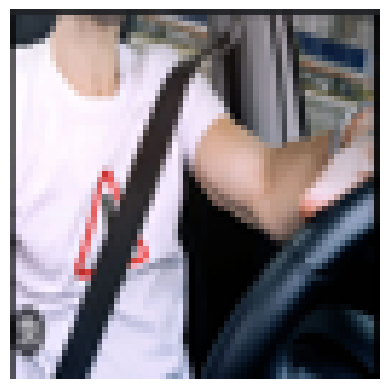

Actual label (y): 0 → Seatbelt
Predicted label (ŷ): 0 → Seatbelt
Confidence: 76.02%


In [38]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

num_px = 64

# Function to predict with confidence
def predict_with_confidence(parameters, X):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    # Forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))   # sigmoid output (probability of class 1)

    prediction = (A2 > 0.5).astype(int)   # threshold at 0.5
    confidence = A2 if prediction == 1 else 1 - A2   # relative confidence
    return prediction, confidence.item()  # <-- fixes the warning

# ==== Test an image ====
def test_image(my_image, actual_y, parameters, num_px):
    # Load and preprocess
    fname = "images/" + my_image   # folder path + filename
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    
    # Show image
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    # Standardize + reshape
    image = image / 255.0
    image = image.reshape((1, num_px * num_px * 3)).T   # shape: (num_px*num_px*3, 1)

    # Predict
    pred, conf = predict_with_confidence(parameters, image)

    # Print results
    print(f"Actual label (y): {actual_y} → {'Seatbelt' if actual_y == 0 else 'No Seatbelt'}")
    print(f"Predicted label (ŷ): {int(np.squeeze(pred))} → {'Seatbelt' if pred == 0 else 'No Seatbelt'}")
    print(f"Confidence: {conf*100:.2f}%")

# ==== Example usage ====
# Change these values for each test image
my_image = "random.jpg"   # put your test image file here
actual_y = 0              # 0 = Seatbelt, 1 = No Seatbelt

test_image(my_image, actual_y, parameters, num_px)


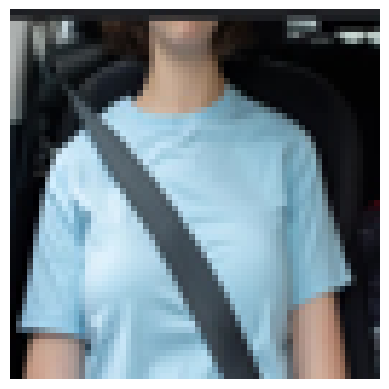

Actual label (y): 0 → Seatbelt
Predicted label (ŷ): 0 → Seatbelt
Confidence: 76.02%


In [40]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

num_px = 64

# Function to predict with confidence
def predict_with_confidence(parameters, X):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    # Forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))   # sigmoid output (probability of class 1)

    prediction = (A2 > 0.5).astype(int)   # threshold at 0.5
    confidence = A2 if prediction == 1 else 1 - A2   # relative confidence
    return prediction, confidence.item()  # <-- fixes the warning

# ==== Test an image ====
def test_image(my_image, actual_y, parameters, num_px):
    # Load and preprocess
    fname = "images/" + my_image   # folder path + filename
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    
    # Show image
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    # Standardize + reshape
    image = image / 255.0
    image = image.reshape((1, num_px * num_px * 3)).T   # shape: (num_px*num_px*3, 1)

    # Predict
    pred, conf = predict_with_confidence(parameters, image)

    # Print results
    print(f"Actual label (y): {actual_y} → {'Seatbelt' if actual_y == 0 else 'No Seatbelt'}")
    print(f"Predicted label (ŷ): {int(np.squeeze(pred))} → {'Seatbelt' if pred == 0 else 'No Seatbelt'}")
    print(f"Confidence: {conf*100:.2f}%")

# ==== Example usage ====
# Change these values for each test image
my_image = "with2.jpg"   # put your test image file here
actual_y = 0              # 0 = Seatbelt, 1 = No Seatbelt

test_image(my_image, actual_y, parameters, num_px)


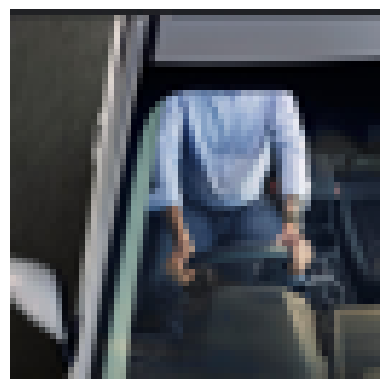

Actual label (y): 0 → Seatbelt
Predicted label (ŷ): 0 → Seatbelt
Confidence: 76.02%


In [42]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

num_px = 64

# Function to predict with confidence
def predict_with_confidence(parameters, X):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    # Forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))   # sigmoid output (probability of class 1)

    prediction = (A2 > 0.5).astype(int)   # threshold at 0.5
    confidence = A2 if prediction == 1 else 1 - A2   # relative confidence
    return prediction, confidence.item()  # <-- fixes the warning

# ==== Test an image ====
def test_image(my_image, actual_y, parameters, num_px):
    # Load and preprocess
    fname = "images/" + my_image   # folder path + filename
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    
    # Show image
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    # Standardize + reshape
    image = image / 255.0
    image = image.reshape((1, num_px * num_px * 3)).T   # shape: (num_px*num_px*3, 1)

    # Predict
    pred, conf = predict_with_confidence(parameters, image)

    # Print results
    print(f"Actual label (y): {actual_y} → {'Seatbelt' if actual_y == 0 else 'No Seatbelt'}")
    print(f"Predicted label (ŷ): {int(np.squeeze(pred))} → {'Seatbelt' if pred == 0 else 'No Seatbelt'}")
    print(f"Confidence: {conf*100:.2f}%")

# ==== Example usage ====
# Change these values for each test image
my_image = "without3.jpg"   # put your test image file here
actual_y = 0              # 0 = Seatbelt, 1 = No Seatbelt

test_image(my_image, actual_y, parameters, num_px)
